# Predicting Medical Insurance Charges with Regression

**Name**: David Rodriguez-Mayorquin 
**Date**: March 26, 2025. 

## Introduction

Intro

-


## 1. Import and Inspect the Data


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1.1 
# Load the dataset
df = pd.read_csv("data/insurance.csv")

# Show the first 10 rows
df.head(10)

# 1.2 
# Check for missing values and display summary statistics.
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())






Missing values in each column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


**Reflection 1**:  
This dataset has 1,338 rows and 7 columns, there aren’t any missing values. The setup looks pretty clean, with numeric columns like age, BMI, and charges, and a few categorical ones like sex, smoker, and region. One thing that stands out is how wide the range of the `charges` column is.
That could mean there are some really high-cost cases that might throw off the model a bit

## 2. Data Exploration and Preparation

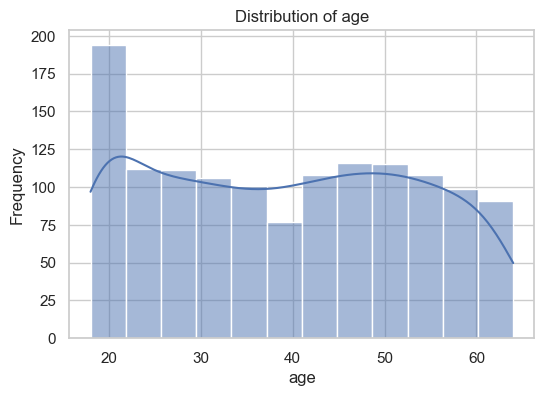

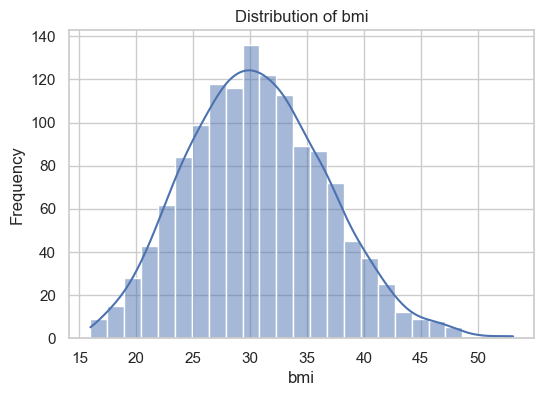

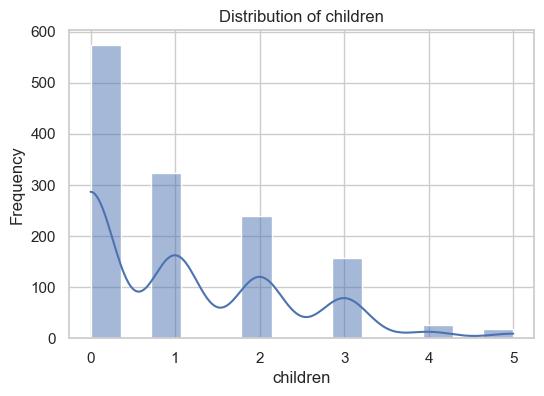

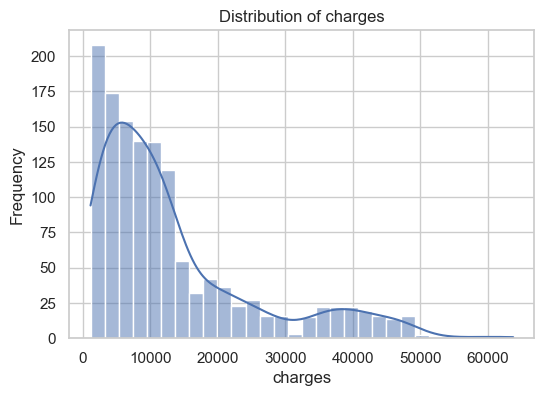

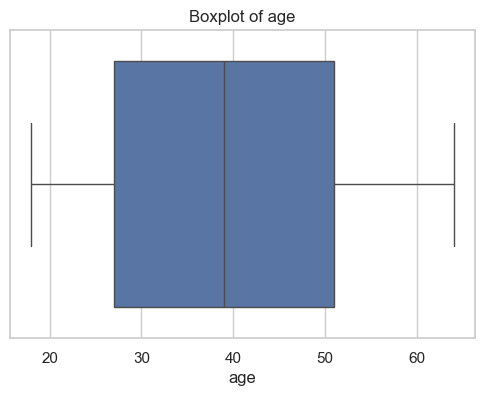

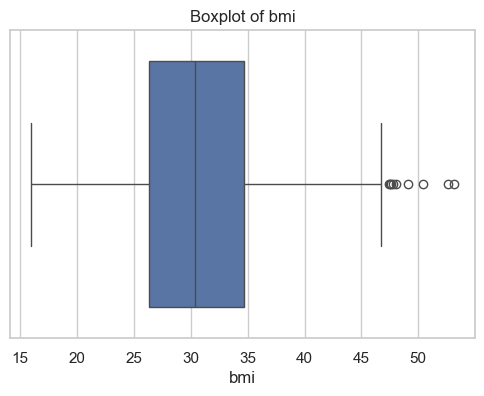

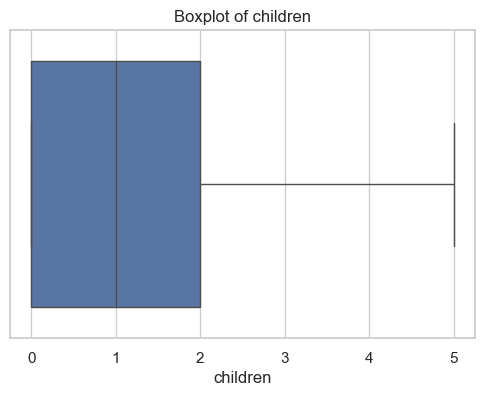

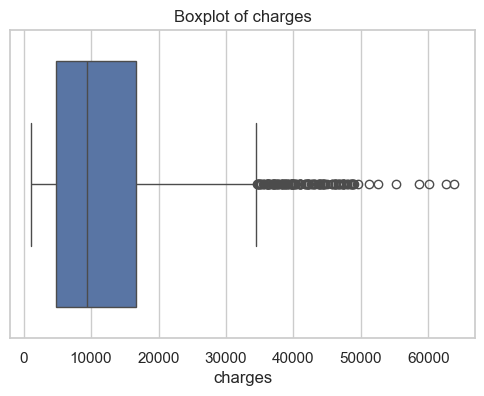

age skewness: 0.06
bmi skewness: 0.28
children skewness: 0.94
charges skewness: 1.52


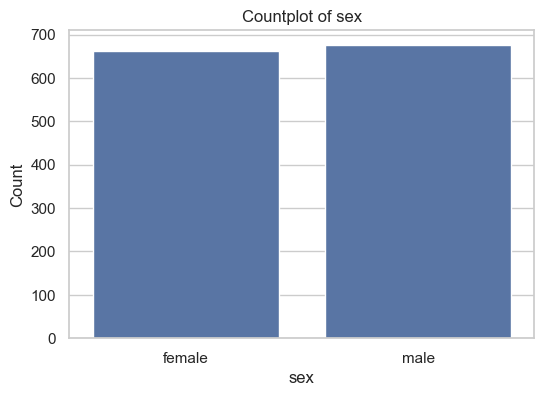

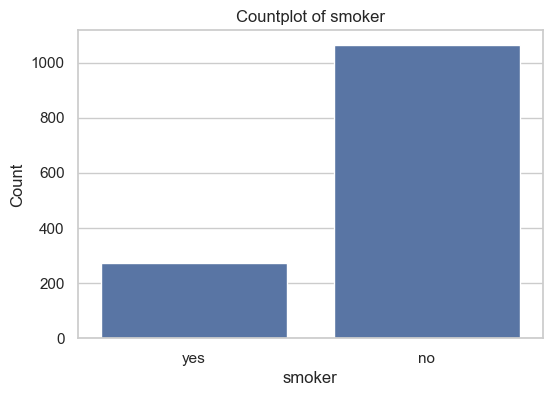

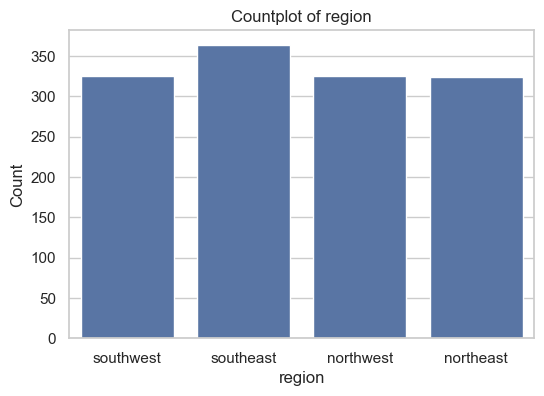

In [13]:
# 2.1
# Set a common style for plots
sns.set(style="whitegrid")

### Histograms for numerical features

numeric_cols = ['age', 'bmi', 'children', 'charges']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Boxplots for spotting outliers

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# Print skewness for numeric columns
for col in numeric_cols:
    print(f"{col} skewness: {df[col].skew():.2f}")

### Count plots for categorical features

categorical_cols = ['sex', 'smoker', 'region']

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.ylabel("Count")
    plt.show()


